# Content

**[Load and Import Data](#heading--1)**

  * [1. Programmatically download and load data.](#heading--1-1)
  
  * [2. Describe the structure of the data.](#heading--1-2)
 

        
**[Make Plots](#heading--2)**

  * [1. Plot a histogram of the transactionAmount column.](#heading--2-1)
  
  * [2. Report any structure you find and any hypotheses you have about that structure.](#heading--2-2)
  
  
**[Data Wrangling - Duplicate Transactions](#heading--3)**

  * [1. Programmatically identify reversed and multi-swipe transactions.](#heading--3-1)
  
      * [1.1. Reversal transaction.](#heading--3-1-1)
      * [1.2. Multi-swipe transaction.](#heading--3-1-2)     
      
  * [2. Total number of transactions and total dollar amount estimated for the reversed transactions and the multi-swipe transactions.](#heading--3-2)
  
  * [3. Anything interesting about either kind of transaction.](#heading--3-3)
      * [3.1. Mechant category of different kinds of duplicates.](#heading--3-3-1)
      * [3.2. Time span between duplicates.](#heading--3-3-2)    
      

**[Model Building.](#heading--4)**

  * [1. Build a predictive model to determine whether a given transaction will be fraudulent or not.](#heading--4-1)
      * [1.1. Missing value.](#heading--4-1-1)
      * [1.2. Feature engineering.](#heading--4-1-2)
      * [1.3. Feature selection.](#heading--4-1-3)
      * [1.4. Preprocess.](#heading--4-1-4)
      * [1.5. SMOTE.](#heading--4-1-5)
      * [1.6. Model building.](#heading--4-1-6)      
      
  * [2. Provide an estimate of performance using an appropriate sample.](#heading--4-2)
  
  * [3. Explain the methodolog.](#heading--4-3) 
      * [3.1. Methodology.](#heading--4-3-1)
      * [1.2. Useful features.](#heading--4-3-2)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import json
import zipfile
import urllib.request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.metrics import classification_report_imbalanced

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb

from sklearn.metrics import (precision_score, recall_score, roc_auc_score, accuracy_score,
                             confusion_matrix, precision_recall_curve, roc_curve, brier_score_loss)

from sklearn.externals import joblib

# Load and Import Data <a name="heading--1"/>

## 1. Programmatically download and load file. <a name="heading--1-1"/>

In [7]:
# Programmatically download the dataset

url = 'https://github.com/Alisaahy/Fraud_detection_ML_project/blob/master/src/transactions.zip?raw=true'
filename, headers = urllib.request.urlretrieve(url, filename='transactions.zip')

print ('download file: ', filename)

download file:  transactions.zip


In [5]:
# Programmatically download the dataset

url = 'https://github.com/CapitalOneRecruiting/DS/blob/master/transactions.zip?raw=true'
filename, headers = urllib.request.urlretrieve(url, filename='transactions.zip')

print ('download file: ', filename)

download file:  transactions.zip


In [8]:
# Load the zipfile

zf = zipfile.ZipFile('transactions.zip', 'r')
zipinfos = zf.infolist()
data = zf.open(zipinfos[0].filename).read().splitlines()


# Convert the json data file into a pandas dataframe

data = [json.loads(rows) for rows in data]
data = pd.DataFrame(data)

BadZipFile: File is not a zip file

In [3]:
# Load the zipfile

zf = zipfile.ZipFile('transactions.zip', 'r')
zipinfos = zf.infolist()
data = zf.open(zipinfos[0].filename).read().splitlines()


# Convert the json data file into a pandas dataframe

data = [json.loads(rows) for rows in data]
data = pd.DataFrame(data)

In [4]:
# Preview the dataset

data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## 2. Describe the structure of the data. Number of records and fields in each record?  <a name="heading--1-2"/>

In [5]:
# We can see that there are multiple blank cells in the dataset, so I will firstly convert these cells into "NaN".

data = data.replace(r'^\s*$', np.nan, regex=True)
data.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [6]:
# Get the shape of the dataset

dshape = data.shape
print(f'This dataset includes {dshape[0]} records and each record contains {dshape[1]} fields.')

This dataset includes 786363 records and each record contains 29 fields.


In [7]:
# Get all column names in the dataset

data.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [8]:
# Get the name and type of each column in the dataset

data.info(verbose=True)
# This dataset has 3 columns containing boolean data, 10 columns containing floating point data and 16 columns containing object data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
accountNumber               786363 non-null object
customerId                  786363 non-null object
creditLimit                 786363 non-null float64
availableMoney              786363 non-null float64
transactionDateTime         786363 non-null object
transactionAmount           786363 non-null float64
merchantName                786363 non-null object
acqCountry                  781801 non-null object
merchantCountryCode         785639 non-null object
posEntryMode                782309 non-null object
posConditionCode            785954 non-null object
merchantCategoryCode        786363 non-null object
currentExpDate              786363 non-null object
accountOpenDate             786363 non-null object
dateOfLastAddressChange     786363 non-null object
cardCVV                     786363 non-null object
enteredCVV                  786363 non-null object
cardLast4Digits    

# Make Plots<a name="heading--2"/>

## 1. Plot a histogram of the processed amounts of each transaction, the transactionAmount column. <a name="heading--2-1"/>

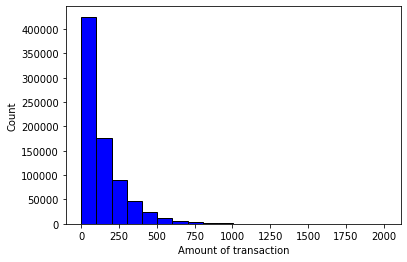

In [85]:
# I firstly get a basic histogram 
# with transaction amount on the x-axis and count of the corresponding amount on the y-axis

plt.hist(data['transactionAmount'], color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

- As we can find in the above histogram, there're some outliers. So I then detect and remove outliers and plot a basic histogram with remaining transaction values

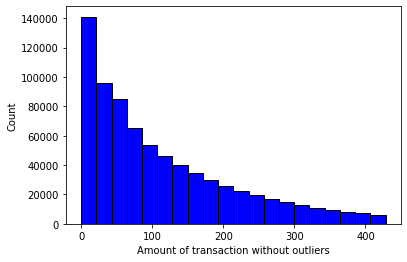

In [86]:
# Generally speaking, transaction values should be no less than 0, so I remove values which < 0 
# According to the definition of outlier, I also remove values which are greater than Q3 + 1.5IQR
q1, q3 = np.percentile(sorted(data.transactionAmount),[25,75])
iqr = q3 - q1
lower_bound = 0
upper_bound = q3 + (1.5 * iqr) 
x = data.transactionAmount[data.transactionAmount.between(lower_bound, upper_bound)]

plt.hist(x, color='blue', edgecolor='black', bins=20)
plt.xlabel('Amount of transaction without outliers', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

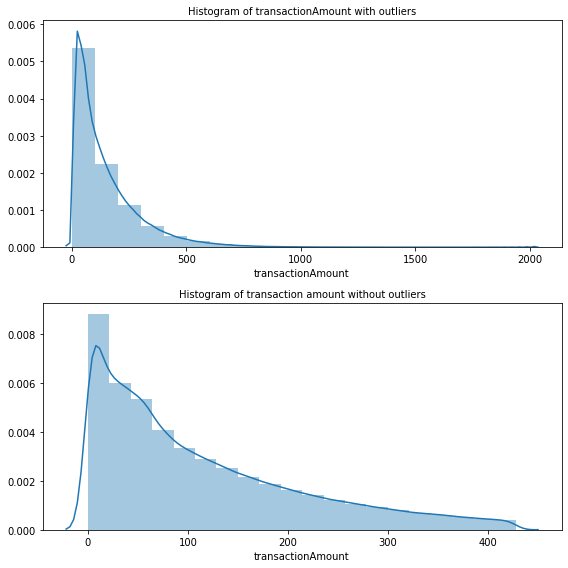

In [87]:
# Make kernel density estimate plots of transaction amount

# A KDE plot of transactions with outliers
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
sns.distplot(data['transactionAmount'], hist=True, bins=20, kde=True, ax=ax[0])
ax[0].set_title('Histogram of transactionAmount with outliers', fontsize=10)

# A KDE plot of transactions without outliers
sns.distplot(x, hist=True, bins=20, kde=True, ax=ax[1])
ax[1].set_title('Histogram of transaction amount without outliers', fontsize=10)
plt.tight_layout()
plt.show()

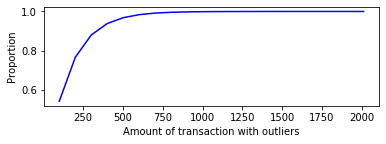

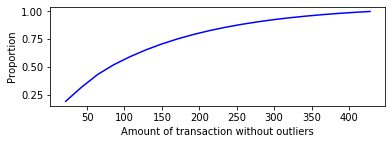

In [88]:
# Make cumulative distribution plots of transaction amount

# A cumulative distribution plot of transactions with outliers
plt.subplot(2, 1, 1)
H,X1 = np.histogram(data['transactionAmount'], density=True, bins=20)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, color='blue')
plt.xlabel('Amount of transaction with outliers', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.show()

# A cumulative distribution plot of transactions without outliers
plt.subplot(2, 1, 2)
H,X1 = np.histogram(x, density=True, bins=20)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1, color='blue')
plt.xlabel('Amount of transaction without outliers', fontsize=10)
plt.ylabel('Proportion', fontsize=10)
plt.show()

## 2. Report any structure you find and any hypotheses you have about that structure. <a name="heading--2-2"/>

- From the histograms above, we can see that the distribuion of transaction amount is severely right-skewed.
- So I hypothesize that the amount of a valid transaction is highly possible to lie between 0 to 500. And from the cumulative distribution plots, we can say that half of transactions will be less than 100.

# Data Wrangling - Duplicate Transactions <a name="heading--3"/>

##  1. Programmatically identify reversed and multi-swipe transactions. <a name="heading--3-1"/>

### 1.1 Reversed transactions <a name="heading--3-1-1"/>

The criteria for a reversed transaction is that a purchase should be followed by a reversal, which indicates that:
- 1. one purchase should have a corrsponding one reversal
- 2. the transactionDateTime of the purchase should be earlier than the reversal

With these 2 criteria, to filter all reversed transactions, basically what I did are:
- 1. selecting duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' to find transactions of same amount within the same account from the same merchant, which are possible to be reversed transactions
- 2. creating 2 seperate datasets pur_tran and rev_tran from the duplicated dataset, one containing all purchasing records from the duplicated dataset and the other containing all reversal records from the duplicated dataset
- 3. inner joining 2 datasets by 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', which means that for every record in the purchasing dataset, if there's a record in the reversal dataset which has the same values in 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', this 2 records will be merged into a new dataset. In the new dataset, features with suffix_x refers to the features from the original purchasing data, features with suffix_y refers to variables from the reversal data
- 4. selecting rows which its purchasing transaction DateTime is earlier than its reversal transaction DateTime

In [49]:
# Convert time columns to standard format

data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'], infer_datetime_format=True)
data['currentExpDate'] = pd.to_datetime(data['currentExpDate'], infer_datetime_format=True)
data['accountOpenDate'] = pd.to_datetime(data['accountOpenDate'], infer_datetime_format=True)
data['dateOfLastAddressChange'] = pd.to_datetime(data['dateOfLastAddressChange'], infer_datetime_format=True)

In [89]:
# Select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' 

duplicated = data[data.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]

In [90]:
# Get all records whose transaction type is purchase from the duplicated data

pur_tran = duplicated[duplicated.transactionType == 'PURCHASE']

In [91]:
# Get all records whose transaction type is reversal from the duplicated data

rev_tran = duplicated[duplicated.transactionType == 'REVERSAL']

In [92]:
# Inner joined the 2 datasets by 'accountNumber', 'customerId', 'transactionAmount', 'merchantName'

reversed_trans = pd.merge(pur_tran, rev_tran, on=['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], how='inner')
reversed_trans.head()

,accountNumber,customerId,creditLimit_x,availableMoney_x,transactionDateTime_x,transactionAmount,merchantName,acqCountry_x,merchantCountryCode_x,posEntryMode_x,...,echoBuffer_y,currentBalance_y,merchantCity_y,merchantState_y,merchantZip_y,cardPresent_y,posOnPremises_y,recurringAuthInd_y,expirationDateKeyInMatch_y,isFraud_y
0,574788567,574788567,2500.0,2416.11,2016-05-24 01:35:33,215.13,Convenient Tire,US,US,09,...,NaN,299.02,NaN,NaN,NaN,True,NaN,NaN,False,False
1,924729945,924729945,50000.0,50000.00,2016-10-04 04:20:04,168.57,discount.com,US,US,05,...,NaN,168.57,NaN,NaN,NaN,False,NaN,NaN,False,False
2,984504651,984504651,50000.0,49138.85,2016-01-06 04:08:06,83.64,1st Sandwitch Bar #801388,US,US,09,...,NaN,11909.30,NaN,NaN,NaN,True,NaN,NaN,False,False
3,984504651,984504651,50000.0,46818.15,2016-01-16 09:52:30,450.74,Planet Fitness #849960,US,US,05,...,NaN,3632.59,NaN,NaN,NaN,False,NaN,NaN,False,False
4,984504651,984504651,50000.0,46341.05,2016-01-17 08:13:08,81.73,AMC #724446,US,US,09,...,NaN,8090.70,NaN,NaN,NaN,True,NaN,NaN,False,False


In [93]:
# Select rows which its purchasing transaction DateTime is earlier than its reversal transaction DateTime.

reversed_trans = reversed_trans[reversed_trans.transactionDateTime_x < reversed_trans.transactionDateTime_y]

In [94]:
# The final reversal transaction data

reversed_trans[['accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionDateTime_x', 'transactionDateTime_y',
                'transactionType_x', 'transactionType_y']].head()

,accountNumber,customerId,transactionAmount,merchantName,transactionDateTime_x,transactionDateTime_y,transactionType_x,transactionType_y
0,574788567,574788567,215.13,Convenient Tire,2016-05-24 01:35:33,2016-05-24 01:38:03,PURCHASE,REVERSAL
1,924729945,924729945,168.57,discount.com,2016-10-04 04:20:04,2016-10-19 14:01:45,PURCHASE,REVERSAL
2,984504651,984504651,83.64,1st Sandwitch Bar #801388,2016-01-06 04:08:06,2016-02-04 00:14:42,PURCHASE,REVERSAL
3,984504651,984504651,450.74,Planet Fitness #849960,2016-01-16 09:52:30,2016-01-16 09:53:15,PURCHASE,REVERSAL
4,984504651,984504651,81.73,AMC #724446,2016-01-17 08:13:08,2016-01-25 20:39:15,PURCHASE,REVERSAL


In [95]:
reversed_trans.to_csv('reversed_trans.csv')

### 1.2 Multi-swipe transactions <a name="heading--3-1-2"/>

The criteria for a multi_swipe transaction is that a vendor accidentally charges a customer's card multiple times within a short time span, which indicates that:
- 1. there should be multiple purchases with the same transaction amount
- 2. the transaction DateTime of different purchases should be within a short time span. I assume they are within 1 hour

With these 2 criteria, to filter all reversed transactions, I will:
- 1. select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' and 'transactionType' to find transactions of same amount within the same account from the same merchant, which are possible to be multi-swipe transaction
- 2. select records whose transaction type is purchasing
- 3. group purchasing dataset and apply a function to calculate the time span between transactions with the same amount from the merchant
- 4. select rows which transaction time span is less than 1 hour

In [96]:
# Select duplicated rows based on 'accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionType'

duplicated = data[data.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName', 'transactionType'], 
                                  keep=False)]

In [97]:
# Select purchasing transactions and sort the purchasing data by transactionDateTime

purchase = duplicated[duplicated.transactionType == 'PURCHASE']
purchase.sort_values(['accountNumber', 'customerId', 'merchantName', 'transactionDateTime'])
purchase.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
2,737265056,737265056,5000.0,5000.00,2016-11-08 09:18:39,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10 02:14:50,7.47,Play Store,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
11,830329091,830329091,5000.0,5000.00,2016-12-07 16:34:04,40.75,GreenCook,US,US,09,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
12,830329091,830329091,5000.0,4959.25,2016-12-14 10:00:35,40.75,GreenCook,US,US,09,...,NaN,40.75,NaN,NaN,NaN,False,NaN,NaN,False,False
13,830329091,830329091,5000.0,4918.50,2016-12-20 18:38:23,40.75,GreenCook,US,US,09,...,NaN,81.50,NaN,NaN,NaN,False,NaN,NaN,False,False


In [98]:
# Group the purchasing dataset and apply a function to calculate the time span

def span(df):
    df['time_span'] = df["transactionDateTime"].diff(1).dt.total_seconds() / 3600
    return df

multi_purchase = purchase.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount']).apply(span)

In [99]:
# Select rows which transaction time span is less than 1 hour

multi_swipe = multi_purchase[multi_purchase.time_span < 1]
multi_swipe.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,time_span
263,984504651,984504651,50000.0,26680.99,2016-03-12 06:34:29,118.52,AMC #706324,US,US,02,...,23319.01,NaN,NaN,NaN,True,NaN,NaN,False,False,0.004444
264,984504651,984504651,50000.0,26562.47,2016-03-12 06:36:41,118.52,AMC #706324,US,US,02,...,23437.53,NaN,NaN,NaN,True,NaN,NaN,False,False,0.036667
281,984504651,984504651,50000.0,24316.12,2016-03-18 13:57:04,26.71,Planet Fitness #692929,US,US,02,...,25683.88,NaN,NaN,NaN,True,NaN,NaN,False,False,0.012222
339,984504651,984504651,50000.0,16503.49,2016-04-08 22:21:11,43.21,WSC #994275,US,US,02,...,33496.51,NaN,NaN,NaN,False,NaN,NaN,False,False,0.010556
413,984504651,984504651,50000.0,7302.32,2016-05-07 07:32:54,23.82,Golds Gym #846582,US,US,09,...,42697.68,NaN,NaN,NaN,True,NaN,NaN,False,False,0.047778


##  2. Total number of transactions and total dollar amount estimated for the reversed transactions and the multi-swipe transactions. <a name="heading--3-2"/>

In [100]:
print(f"The total number of transactions for reversed transactions is {reversed_trans.shape[0]}.")
print(f"The total dollar estimated  for reversed transactions is {reversed_trans.transactionAmount.sum()}.")
print(f"The total number of multi-swipe transactions is {multi_swipe.shape[0]}.")
print(f"The total dollar estimated  for reversed transactions is {multi_swipe.transactionAmount.sum()}.")

The total number of transactions for reversed transactions is 17999.
The total dollar estimated  for reversed transactions is 2701311.87.
The total number of multi-swipe transactions is 7450.
The total dollar estimated  for reversed transactions is 1103132.25.


##  3. Anything interesting about either kind of transaction. <a name="heading--3-3"/>

### 3.1. Mechant category of different kinds of duplicates <a name="heading--3-3-1"/>

I want to know whether the type of merchant will have impact on the likelihood of duplicate transactions. So I will build a table for proportions of reversed transaction and multi-swipe in different types of merchant and see if there're some interesting patterns.

In [101]:
# Get proportion of different types of merchant

all_pro = data.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('overall_proportion')
rev_pro = reversed_trans.merchantCategoryCode_x.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('reversed_proportion')
mul_pro = multi_swipe.merchantCategoryCode.value_counts(normalize=True).rename_axis('MerchantCategory').to_frame('multi_proportion')

In [102]:
# Compare proportion of different types of merchant# Get proportion of 

mer_pro = all_pro.merge(rev_pro, how='left', on=['MerchantCategory']).merge(mul_pro, how='left', on=['MerchantCategory'])
mer_pro

,overall_proportion,reversed_proportion,multi_proportion
MerchantCategory,,,
online_retail,0.257077,0.275460,0.275705
fastfood,0.142603,0.155620,0.160000
entertainment,0.101859,0.108950,0.115302
food,0.095999,0.104784,0.103221
online_gifts,0.084233,0.095116,0.089799
rideshare,0.065028,0.067782,0.068456
hotels,0.043360,0.049725,0.045235
fuel,0.030406,NaN,NaN
subscriptions,0.029123,0.030502,0.031141


- From the above dataset we can see that,generally speaking, merchants who account for a higher proportion of overall transactions are also more likely to have reversed transactions and multi-swipe transactions. This also means that most of merchant don't have a much higher or lower possibility to give reversed transactions or multi-swipe transactions.
- However, for fuel merchants, they account for more than 3% in the overall transaction data but don't have any records in the  reversed transactions and multi-swipe transactions data. This means that fuel merchants have very lower possibility to give reversed transactions or multi-swipe transactions to their customers.

### 3.2. Time span between duplicates <a name="heading--3-3-2"/>

- I want to know what's the typical time span between reversed transactions and multi-swipe transactions. So I firstly add time span to the reversed transactions data. Then make a plot to visualize their time span and compare them.

In [103]:
# Add time span of reversed transactions

reversed_trans['time_span'] = ((reversed_trans.transactionDateTime_y - 
                               reversed_trans.transactionDateTime_x) / np.timedelta64(1, 'D')).astype(int)

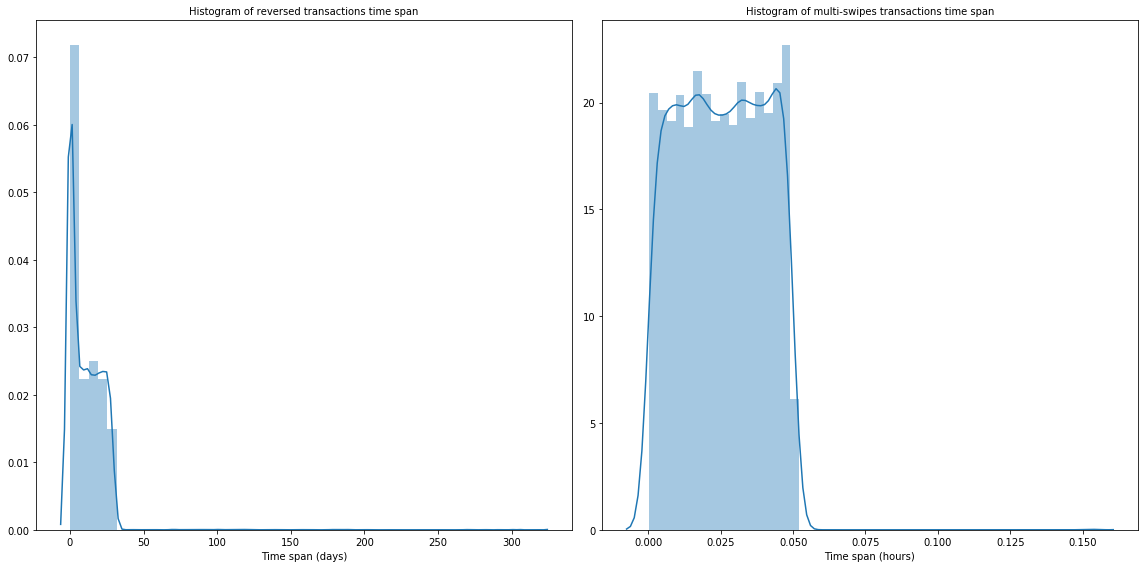

In [104]:
# Make distribution plots to visualize their time span and compare

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.distplot(reversed_trans.time_span, hist=True, kde=True, ax=ax[0])
ax[0].set_xlabel('Time span (days)')
ax[0].set_title('Histogram of reversed transactions time span', fontsize=10)

# A KDE plot of transactions without outliers
sns.distplot(multi_swipe.time_span, hist=True, kde=True, ax=ax[1])
ax[1].set_xlabel('Time span (hours)')
ax[1].set_title('Histogram of multi-swipes transactions time span', fontsize=10)
plt.tight_layout()
plt.show()

- From the above graphs, we can find that there're often days between multiple reversed transactions. And almost all of them happen within 50 days. 
- While multi-swipe transactions often happen within few seconds. Almost all of them happen within 3 minutes.

# Model Building <a name="heading--4"/>

##  1. Build a predictive model to determine whether a given transaction will be fraudulent or not.  <a name="heading--4-1"/>

In [105]:
# Make a copy of the original dataset for model building
df = data.copy()

### 1.1. Missing value <a name="heading--4-1-1"/>

In [106]:
# Drop columns with no records
df = df.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'
], axis=1)

In [107]:
# Inspect missing values columns

missingValueColumns = df.columns[df.isnull().any()].tolist()
percent_missing = df[missingValueColumns].isnull().sum() / len(df)
print(percent_missing)

acqCountry             0.005801
merchantCountryCode    0.000921
posEntryMode           0.005155
posConditionCode       0.000520
transactionType        0.000888
dtype: float64


From the missing value table, we can see that the missing percentage in all columns are low. So we don't need to drop these columns but we can find some proper ways to impute missing values.

In [108]:
# Inspect missing values columns

print("Frequency of values in column acqCountry: \n",df.acqCountry.value_counts())
print("Frequency of values in column merchantCountryCode: \n",df.merchantCountryCode.value_counts())
print("Frequency of values in column posEntryMode: \n",df.posEntryMode.value_counts())
print("Frequency of values in column posConditionCode: \n",df.posConditionCode.value_counts())
print("Frequency of values in column transactionType: \n",df.transactionType.value_counts())

Frequency of values in column acqCountry: 
 US     774709
MEX      3130
CAN      2424
PR       1538
Name: acqCountry, dtype: int64
Frequency of values in column merchantCountryCode: 
 US     778511
MEX      3143
CAN      2426
PR       1559
Name: merchantCountryCode, dtype: int64
Frequency of values in column posEntryMode: 
 05    315035
09    236481
02    195934
90     19576
80     15283
Name: posEntryMode, dtype: int64
Frequency of values in column posConditionCode: 
 01    628787
08    149634
99      7533
Name: posConditionCode, dtype: int64
Frequency of values in column transactionType: 
 PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64


In [109]:
# We can see that all those 5 columns contain categorical variables and are skewed to one of a category.
# So I will use mode to impute these columns.

df['acqCountry'] = df['acqCountry'].fillna(df['acqCountry'].mode()[0])
df['merchantCountryCode'] = df['merchantCountryCode'].fillna(df['merchantCountryCode'].mode()[0])
df['posEntryMode'] = df['posEntryMode'].fillna(df['posEntryMode'].mode()[0])
df['posConditionCode'] = df['posConditionCode'].fillna(df['posConditionCode'].mode()[0])
df['transactionType'] = df['transactionType'].fillna(df['transactionType'].mode()[0])

### 1.2. Feature engineering <a name="heading--4-1-2"/>

The original dataset contains a number of features but some of them don't tell much valuable information. So I will convert to a new feature, which I believe will be more related to fraud detection.

### 1.2.1. rightCVV <a name="heading--4-1-2-1"/>
The original dataset has 2 columns, "cardCVV" and "enteredCVV". I will convert these 2 columns to be a dummy feature: "rightCVV". If cardCVV = enteredCVV, rightCVV = 1, otherwise, rightCVV = 0. The reason I do this is that typically, the card's verification value adds extra security to transaction. So if the entered CVV is incorrect, it's highly possible that this transaction would be fraud.

In [110]:
# Convert cardCVV and enteredCVV to rightCVV

df['rightCVV'] = (df.cardCVV == df.enteredCVV).astype(int)
df = df.drop(['cardCVV', 'enteredCVV'], axis=1)

### 1.2.2. sameCountry <a name="heading--4-1-2-2"/>
The original dataset has 2 columns, "acqCountry" and "merchantCountryCode". I will convert these 2 columns to be a dummy feature: "sameCountry". If acqCountry = merchantCountryCode, sameCountry = 1, otherwise, sameCountry = 0. The reason I do this is that most of the time, people will use their cards in the country they acquired cards. If they use their cards in some other countries, it's possible that this transaction would be fraud.

In [111]:
# Convert acqCountry and merchantCountryCode to sameCountry

df['sameCountry'] = (df.acqCountry == df.merchantCountryCode).astype(int)
df = df.drop(['acqCountry', 'merchantCountryCode'], axis=1)

### 1.2.3. Whether first time purchasing merchant <a name="heading--4-1-2-3"/>
The original dataset has a feature "merchantName". Actually just the name can't tell us something valuable. So I will convert this column to be a dummy feature: "firPurchase". If it's the customer's first time purchasing in this merchant, firPurchase = 1, otherwise, firPurchase = 0. The reason I do this is that most of the time, fraud transactions happen in a merchant where the customer hasn't used before.

In [112]:
# Convert merchantName to firPurchase

# Decide whether it's the first record of a certain customer in a certain customer
df = df.sort_values(['customerId', 'merchantName', 'transactionDateTime'])
df['firPurchase'] = df.groupby(['customerId', 'merchantName']).cumcount()
df['firPurchase'][df['firPurchase'] == 0] = 1
df['firPurchase'][df['firPurchase'] > 0] = 0

### 1.2.4. Datetime data <a name="heading--4-1-2-4"/>
The original dataset has multiple date transactionDateTime, currentExpDate, accountOpenDate and dateOfLastAddressChange. I want to convert these datetime features into time interval features, which are more informative. 
- For currentExpDate, I will change it to expTime, which indicates the time between the transaction date and the expiration date. 
- For accountOpenDate, I will change it to openTime, which indicates the time between the account open date and the transaction date.
- For dateOfLastAddressChange, I will change it to changeAddTime, which indicates the time between the last of address change date and the transaction date.

In [113]:
# Convert datetime to time span (days)
df['expTime'] = ((df.currentExpDate - df.transactionDateTime) / np.timedelta64(1, 'D'))
df['openTime'] = ((df.transactionDateTime - df.accountOpenDate) / np.timedelta64(1, 'D'))
df['changeAddTime'] = ((df.transactionDateTime - df.dateOfLastAddressChange) / np.timedelta64(1, 'D'))

### 1.2.5. Duplicate transactions (reversed transaction and multi-swipes)<a name="heading--4-1-2-5"/>
I will add reversed transaction and multi-swipes as attributes to the dataset because that pratically speaking, duplicate transactions may have higher possibilities to be fraud. So I will add dummy variables to identify whether this transaction is reversed transaction and whetehr this transaction is multi-swipes transaction.

In [114]:
# Subset reversed transactions in the dataset

lst_re = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime_y', 'transactionType_y']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']

df.loc[df.set_index(lst_or).index.isin(reversed_trans.set_index(lst_re).index) == True, 'reversed'] = 1

In [115]:
# if not reversed transaction, reversed = 0

df.reversed = df.reversed.fillna(0)

In [116]:
# Check the number of reversed transactions and other transactions

df.reversed.value_counts()

0.0    768604
1.0     17759
Name: reversed, dtype: int64

In [117]:
# Subset multi-swipe transactions in the dataset

lst_mul = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']
lst_or = ['accountNumber', 'transactionAmount', 'merchantName', 'transactionDateTime', 'transactionType']

df.loc[df.set_index(lst_or).index.isin(multi_swipe.set_index(lst_mul).index) == True, 'multi'] = 1

In [118]:
# if not multi-swipe transaction, multi = 0

df.multi = df.multi.fillna(0)

In [119]:
# Check the number of multi-swipe transactions

df.multi.value_counts()

0.0    778913
1.0      7450
Name: multi, dtype: int64

### 1.3. Feature selection <a name="heading--4-1-3"/>

- I will firstly drop some columns which will not be useful for model building. 
     1. accountNumber, customerId and cardLast4Digits, which are just identifiers for each card
     2. As I explained before,  I will drop merchantName and datetime variables including: transactionDateTime, currentExpDate, accountOpenDate and dateOfLastAddressChange
     3. availableMoney, which is highly related to creditLimit and currentBalance. availableMoney = creditLimit - currentBalance
     
- Check correlation matrix to see if remaining features are correlated

In [120]:
df = df.drop(['accountNumber', 'customerId', 'cardLast4Digits', 'merchantName', 'transactionDateTime',
             'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'availableMoney'], axis=1)

In [121]:
# Create correlation matrix and select upper triangle of correlation matrix

corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

,creditLimit,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,rightCVV,sameCountry,firPurchase,expTime,openTime,changeAddTime,reversed,multi
creditLimit,NaN,0.005581,0.653652,0.003929,0.002391,0.003108,0.001343,0.000435,NaN,0.001460,0.061550,0.062469,0.001585,0.001879
transactionAmount,NaN,NaN,0.023905,0.037361,0.001751,0.075651,0.000701,0.002096,NaN,0.002073,0.007879,0.028430,0.013546,0.007339
currentBalance,NaN,NaN,NaN,0.010529,0.001285,0.007715,0.003221,0.001113,NaN,0.004031,0.081993,0.169767,0.007321,0.005135
cardPresent,NaN,NaN,NaN,NaN,0.040393,0.043418,0.002988,0.000816,NaN,0.000097,0.020536,0.013711,0.005678,0.005805
expirationDateKeyInMatch,NaN,NaN,NaN,NaN,NaN,0.000972,0.000113,0.000419,NaN,0.000886,0.001220,0.001014,0.002953,0.000403
isFraud,NaN,NaN,NaN,NaN,NaN,NaN,0.010006,0.000570,NaN,0.001772,0.005899,0.005933,0.001550,0.001196
rightCVV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001091,NaN,0.001445,0.000047,0.001246,0.000767,0.001192
sameCountry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001238,0.000514,0.000833,0.001229,0.002300
firPurchase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expTime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.013492,0.003807,0.000334,0.001429


- We can see that all their correlation is less than 0.7, so I will keep these features right now.

### 1.4. Preprocess <a name="heading--4-1-4"/>

In [122]:
# Convert categorical features into dummy variables

cat = df.select_dtypes(include=['object']).columns.to_list()
df = pd.get_dummies(df, cat, drop_first=True)

In [123]:
# Convert boolean features into int variables

boo = df.select_dtypes(include=['bool']).columns.to_list()
for column in boo:
    df[column] = df[column].astype(int)
df.reversed = df.reversed.astype(int)
df.multi = df.multi.astype(int)

### 1.5. SMOTE <a name="heading--4-1-5"/>
- As we can see in our data analysis part, our target variabel isFraud is highly imbalanced, where there're 773946 negative class but only 12417 positive class. So I decide to use SMOTE to over-sample the dataset.
- SMOTE generates the virtual training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed

In [124]:
# Using SMOTE to oversample the dataset
X = df.drop(['isFraud'], axis = 1)
y = df[['isFraud']]

sm = SMOTE(random_state=4)
X_smote, y_smote = SMOTE().fit_sample(X, y)

print("Original data distribution: ")
print(y.isFraud.value_counts())
print("SMOTE data distribution: ")
print(y_smote.isFraud.value_counts())

Original data distribution: 
0    773946
1     12417
Name: isFraud, dtype: int64
SMOTE data distribution: 
1    773946
0    773946
Name: isFraud, dtype: int64


### 1.6. Model building <a name="heading--4-1-6"/>
- In the model building part, I use RandomSearchCV and K-Folds CV to optimize my model. 

#### 1.6.1. Decision Tree model <a name="heading--4-1-6-1"/>
- The decision true are generally in form of if-then-else statements. The deeper the tree, the more complex the rules and fitter the model. 

- I will try decision tree model first because it's a very interpretable model and it's very transparent. If we are going to show the workflow of our machine learning model to our non-technical clients, decision tree may be a good choice. We can easily visualize our decision tree model.

In [125]:
def DT_pred(X, y):
    
    # Build models with hyperparameters sets
    RSC = RandomizedSearchCV(
        estimator=DecisionTreeClassifier(),
        param_distributions={
            'criterion': ['gini', 'entropy'],
            'max_depth': range(1, 100, 10),
            'max_features': ['auto', 'sqrt', 'log2']}, 
        cv=3, scoring='roc_auc', n_jobs=-1, verbose = True)
    
    # Fit RandomizedSearchCV to find best hyperparameters
    search_result = RSC.fit(X, y)
    print("Best using: ", search_result.best_params_, "Score: ", search_result.best_score_)

    # Build models with optimized hyperparameters
    model_DT = DecisionTreeClassifier(
        criterion=search_result.best_params_["criterion"],
        max_depth=search_result.best_params_["max_depth"],
        max_features=search_result.best_params_["max_features"])

    # Split dataset into 3 consecutive folds
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    
    i = 1
    for train, test in kf.split(X):  
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_DT.fit(X_train, y_train)
        train_pred = model_DT.predict(X_train)
        y_pred = model_DT.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred)        
        
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)
        
        i += 1
        
    return model_DT

In [126]:
model_DT = DT_pred(X_smote, y_smote)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.3s finished


Best using:  {'max_features': 'log2', 'max_depth': 31, 'criterion': 'gini'} Score:  0.940317706475895
Fold 1 :  Training accuracy:  0.9502290857501686 Testing accuracy:  0.9308866510066593
Fold 1 :  Training precision:  0.9273751242316045 Testing precision:  0.9065878242564669
Fold 1 :  Training recall:  0.976928147659855 Testing accuracy:  0.9608778847718135
Fold 1 :  Training auc:  0.9502386036159579 Testing auc:  0.9308652451500865
Fold 2 :  Training accuracy:  0.9594758549046057 Testing accuracy:  0.9362610569729671
Fold 2 :  Training precision:  0.9421960683406891 Testing precision:  0.9168056451194474
Fold 2 :  Training recall:  0.9790420611901288 Testing accuracy:  0.9595100400671794
Fold 2 :  Training auc:  0.9594695958307472 Testing auc:  0.9362759170418834
Fold 3 :  Training accuracy:  0.9548747587040957 Testing accuracy:  0.9326561543053391
Fold 3 :  Training precision:  0.93441609520901 Testing precision:  0.910976256407235
Fold 3 :  Training recall:  0.9784256458061603 Tes

#### 1.6.2. Random Forest model <a name="heading--4-1-6-2"/>
- Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest splits out a class prediction and the class with the most votes becomes our model’s prediction. 

- I will choose random forest because  random forest work well in such high-dimensional cases. It’s typically less likely to be overfit.

In [131]:
def RF_pred(X, y):
    
    # Build models with hyperparameters sets
    RSC = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions={
            'n_estimators': range(1, 200, 10),
            'max_depth': range(1, 100, 10),
            'max_features': ['auto', 'sqrt', 'log2']}, cv=3, scoring='roc_auc', n_jobs=-1)
    
    # Fit RandomizedSearchCV to find best hyperparameters
    search_result = RSC.fit(X, y)
    print("Best using: ", search_result.best_params_, "Score: ", search_result.best_score_)

    # Build models with optimized hyperparameters
    model_RF = RandomForestClassifier(
        n_estimators=search_result.best_params_["n_estimators"],
        max_depth=search_result.best_params_["max_depth"],
        max_features=search_result.best_params_["max_features"])
    

    # Split dataset into 5 consecutive folds
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    
    i = 1
    for train, test in kf.split(X):  
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_RF.fit(X_train, y_train)
        train_pred = model_RF.predict(X_train)
        y_pred = model_RF.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred)        
        
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)
        
        i += 1

    return model_RF

In [132]:
model_RF = RF_pred(X_smote, y_smote)

Best using:  {'n_estimators': 191, 'max_features': 'log2', 'max_depth': 61} Score:  0.9932197072717678
Fold 1 :  Training accuracy:  1.0 Testing accuracy:  0.9765390608647115
Fold 1 :  Training precision:  1.0 Testing precision:  0.9701806687153425
Fold 1 :  Training recall:  1.0 Testing accuracy:  0.9832717935988333
Fold 1 :  Training auc:  1.0 Testing auc:  0.9765430775103597
Fold 2 :  Training accuracy:  1.0 Testing accuracy:  0.9762774147033514
Fold 2 :  Training precision:  1.0 Testing precision:  0.9695733547228906
Fold 2 :  Training recall:  1.0 Testing accuracy:  0.9834416817114653
Fold 2 :  Training auc:  1.0 Testing auc:  0.976273635934966
Fold 3 :  Training accuracy:  1.0 Testing accuracy:  0.9764712266747293
Fold 3 :  Training precision:  1.0 Testing precision:  0.9698476520994657
Fold 3 :  Training recall:  1.0 Testing accuracy:  0.9835232558139535
Fold 3 :  Training auc:  1.0 Testing auc:  0.9764707346040352


#### 1.6.3. Light GBM model <a name="heading--4-1-6-2"/>
- Light GBM is an algorithm based on decision tree. Light GBM grows tree vertically. It will choose the leaf with max delta loss to grow. 

- I will choose Light GBM because it has faster training speed and higher efficiency, but at the same time, it typically has higher accuracy.

In [133]:
def LGB_pred(X, y):
    
    # Build models with hyperparameters sets
    RSC = RandomizedSearchCV(
        estimator=lgb.LGBMClassifier(),
        param_distributions = { 'boosting_type': ['gbdt', 'goss', 'dart'],
                      'num_leaves': range(10, 500, 25),
                      'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
                      'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5],
                      'min_data': [200, 300, 400, 500, 600],
                      'max_bin': [3, 5, 10, 12, 15, 18, 20, 22],
                      'lambda_l1': [1, 10, 20, 30, 40],
                      'feature_fraction': [0.5, 0.7, 0.8, 0.9],
                      'max_depth': range(1, 50, 10)}, cv=3, scoring='roc_auc', n_jobs=-1)
    
    # Fit RandomizedSearchCV to find best hyperparameters
    search_result = RSC.fit(X, y)
    print("Best: using", search_result.best_score_, search_result.best_params_)

    # Build models with optimized hyperparameters
    model_LGB = lgb.LGBMClassifier(
        boosting_type=search_result.best_params_["boosting_type"],
        num_leaves=search_result.best_params_["num_leaves"],
        bagging_fraction=search_result.best_params_["bagging_fraction"],
        learning_rate=search_result.best_params_["learning_rate"],
        min_data=search_result.best_params_["min_data"],
        max_bin=search_result.best_params_["max_bin"],
        lambda_l1=search_result.best_params_["lambda_l1"],
        feature_fraction=search_result.best_params_["feature_fraction"],
        max_depth=search_result.best_params_["max_depth"])
    

    # Split dataset into 5 consecutive folds
    kf = KFold(n_splits=3, shuffle=True, random_state=None)
    
    i = 1
    for train, test in kf.split(X):  
        X_train = X.iloc[train,:]
        y_train = y.iloc[train,:]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        model_LGB.fit(X_train, y_train)
        train_pred = model_LGB.predict(X_train)
        y_pred = model_LGB.predict(X_test)
        
        train_accuracy = accuracy_score(y_train, train_pred)
        train_precision = precision_score(y_train, train_pred)
        train_recall = recall_score(y_train, train_pred)
        train_auc = roc_auc_score(y_train, train_pred)
        
        test_accuracy = accuracy_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred)        
        
        print('Fold '+ str(i), ':  Training accuracy: ', train_accuracy, 'Testing accuracy: ', test_accuracy)
        print('Fold '+ str(i), ':  Training precision: ', train_precision, 'Testing precision: ', test_precision)
        print('Fold '+ str(i), ':  Training recall: ', train_recall, 'Testing accuracy: ', test_recall)
        print('Fold '+ str(i), ':  Training auc: ', train_auc, 'Testing auc: ', test_auc)
        
        i += 1

    return model_LGB

In [134]:
model_LGB = LGB_pred(X_smote, y_smote)

Best: using 0.9747786985967029 {'num_leaves': 235, 'min_data': 300, 'max_depth': 21, 'max_bin': 12, 'learning_rate': 0.1, 'lambda_l1': 20, 'feature_fraction': 0.9, 'boosting_type': 'goss', 'bagging_fraction': 0.1}
Fold 1 :  Training accuracy:  0.9304302238140646 Testing accuracy:  0.9281694071679419
Fold 1 :  Training precision:  0.9283542232650037 Testing precision:  0.9266024243313021
Fold 1 :  Training recall:  0.9328052206382719 Testing accuracy:  0.9301057149608556
Fold 1 :  Training auc:  0.9304309830709091 Testing auc:  0.9281681679525844
Fold 2 :  Training accuracy:  0.9297567272135265 Testing accuracy:  0.9294485661790357
Fold 2 :  Training precision:  0.9274900367695237 Testing precision:  0.9267315817066025
Fold 2 :  Training recall:  0.9324604469312708 Testing accuracy:  0.9325262602597322
Fold 2 :  Training auc:  0.9297557941480502 Testing auc:  0.9294506882333678
Fold 3 :  Training accuracy:  0.9298449116605034 Testing accuracy:  0.9285143924769945
Fold 3 :  Training prec

In [232]:
# Save my models as pickle files
joblib.dump(model_DT, "model_DT.pkl")
joblib.dump(model_RF, "model_RF.pkl")
joblib.dump(model_LGB, "model_LGB.pkl")

['model_LGB.pkl']

## 2. Provide an estimate of performance using an appropriate sample. <a name="heading--4-2"/>

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, random_state=2, test_size=0.30)

In [196]:
def plot_performance(y_test, y_pred, y_pred_prob):


    test_fpr, test_tpr, _ = roc_curve(y_test, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    
    # ROC Curve
    fig = plt.figure(1, figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(test_fpr, test_tpr, label="ROC (area = %0.4f)" % roc_auc_score(y_test, y_pred), color="blue", lw=2)
    plt.plot([0, 1], [0, 1], "k--")
    plt.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    
    
    # Precision Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, marker='.', color="blue", lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("Precision Recall Curve")
    
    
    plt.tight_layout()
    plt.show()

In [197]:
def plot_confusion(y_test, y_pred):   
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Confusion Matrix
    plt.figure(figsize=(10,10))
    ax =  fig.add_subplot(1,1,1, adjustable='box', aspect=1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    np.set_printoptions(precision=2)
    plt.show()
    

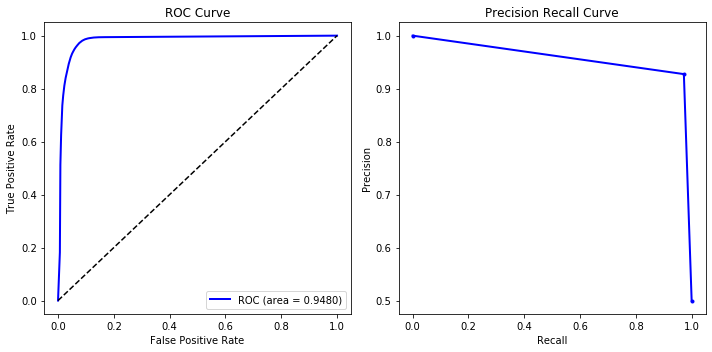

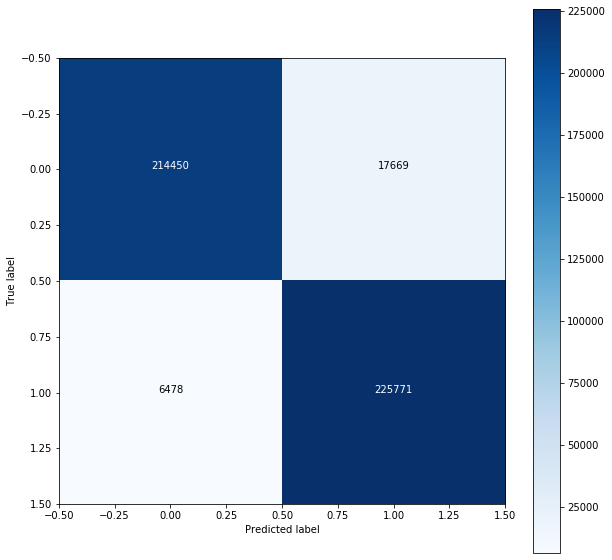

In [198]:
# Decision Tree performance

y_pred = model_DT.predict(X_test)
y_pred_prob = model_DT.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]

plot_performance(y_test, y_pred, y_pred_prob)
plot_confusion(y_test, y_pred)

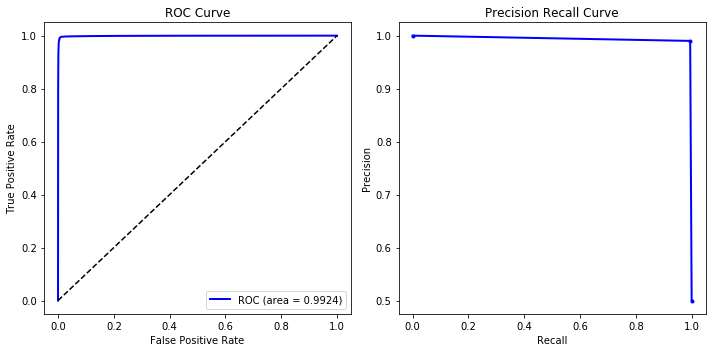

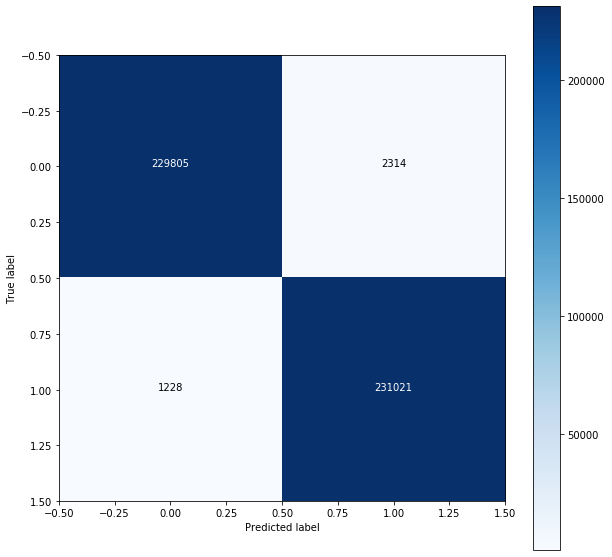

In [199]:
# Random Forest performance
y_pred = model_RF.predict(X_test)
y_pred_prob = model_RF.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]

plot_performance(y_test, y_pred, y_pred_prob)
plot_confusion(y_test, y_pred)

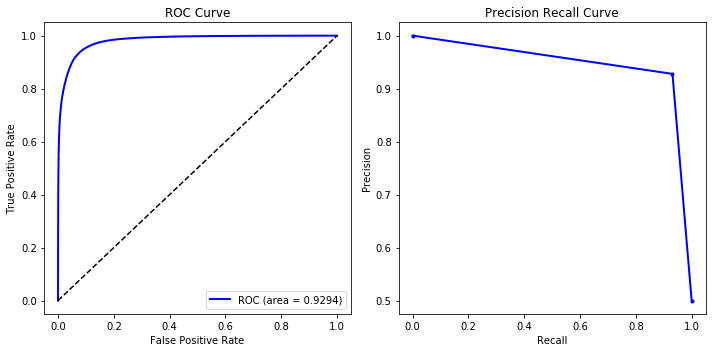

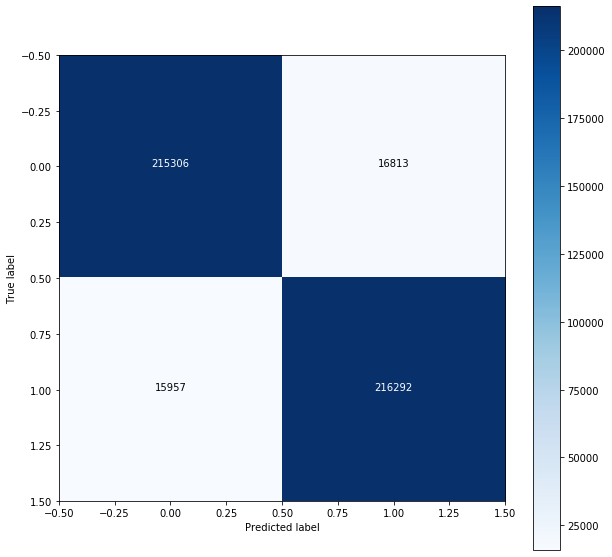

In [200]:
# LGB performance
y_pred = model_LGB.predict(X_test)
y_pred_prob = model_LGB.predict_proba(X_test)
y_pred_prob = y_pred_prob[:, 1]

plot_performance(y_test, y_pred, y_pred_prob)
plot_confusion(y_test, y_pred)

I made 3 plots to evaluate each of these three model, ROC Curve, Precision-recall Curve and Confusion Matrix.

- ROC Curve:
ROC Curve shows the dependency between TPR (True Positive Rate) and FPR (False Positive Rate). The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive. The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.
A skilled model should have an area of 1.0 under the curve, which is AUC. The curve of our random forest model are the closest to the top left corner, which means that this model has the highes AUC score.


- Precision-Recall Curve:
Precision-Recall curve shows the trade-off between the true positive rate and the positive predictive value for a predictive model
Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value. Recall is the ratio of the number of true positives divided by the sum of the true positives and the false negatives.
A skilled model should also have an area of 1.0 under the curvel, which means that it has both high precision and high recall. Our random forest model also outperforms the other two.


- Confusion matrix:
Confusion matrix directly gives the number of correct and incorrect classifications made by the classifier.The left diagonal shows the number of correct predictions made for each class while the right diagonal shows the number of wrong predictions made. Upper right counts false positive case. Lower left counts false negative cases.
Our random forest model also has the lowest false cases. It's false positive case is 2314 and false negative case is 1228. False positive means that the model incorrectly labels a legitimate transaction as fraudulent, and false negative means that the model mistakenly ignore a fraudulent transaction and labels it as normal. 


Source: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

## 3. Explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time) <a name="heading--4-3"/>

### 3.1. Methodology <a name="heading--4-3-1"/>

- SMOTE: 
In the original dataset, the class within our target variable “isFraud” is quite imbalanced. Fraud cases are much less than normal cases. So I will use SMOTE function to oversample my dataset. SMOTE generates the virtual training records by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and the performance of our classification models can be better.

- Cross validation: cross validation is an algorithm that can ensure that each and every instance of the dataset will be trained and tested. The K-Fold Cross Validation works by first dividing the dataset into k-subsets. I divided the dataset into (k=3) parts. We reserve 1 part for testing and train the algorithm over the 2 parts. We continue the process by changing the testing part in each iteration and training the algorithm over the other parts. The accuracies and errors are then averaged of the algorithm. With cross-validation, we can achieve a generalized model.

- RandomizedSearchCV: Random Search is a hyperparameter tuning algorithm. It helps us select models by setting up a grid of hyperparameter values and selecting random combinations to train the model and score. This allows us to explicitly control the number of parameter combinations that are attempted. It’s more efficient than GridSearchCV and its chance of finding the optimal parameter are comparatively.

- Decision Tree: Decision tree is a non-parametric supervised learning method. The rule for decision tree algorithm are generally in form of if-then-else statements. The deeper the tree, the more complex the rules and fitter the model. The reason why I use decision trees is that it's a very interpretable model and it's very transparent. If we are going to show the workflow of our machine learning model to our non-technical clients, decision tree may be a very good choice. We can easily visualize our decision tree model.

- Random forest: 
Random forest consists of a large number of individual decision trees that operate as an ensemble. Each individual tree in the random forest splits out a class prediction and the class with the most votes becomes our model’s prediction. I choose random forest because random forest works well in such high-dimensional cases. It’s typically less likely to be overfit.

- Light GBM: 
Light GBM is a gradient boosting framework that uses tree based learning algorithms. Light GBM grows tree vertically. It will choose the leaf with max delta loss to grow.
I choose Light GBM because it has faster training speed and higher efficiency, but at the same time, it typically has higher accuracy.

### 3.2. Useful features <a name="heading--4-3-2"/>

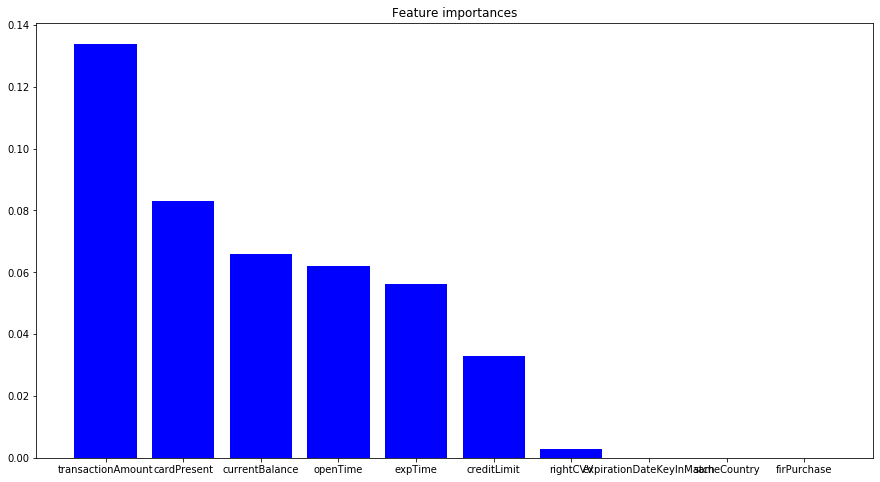

In [228]:
# Plot the feature importances of the Random Forest

importances = model_RF.feature_importances_
indices = np.argsort(importances)[::-1]

top_10= 10
top_indices = indices[:top_10]

plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(10), importances[top_indices], align="center", color="blue")
plt.xticks(range(10), np.array(X.columns)[indices][0:10])
plt.show()

From the feature importance plot above, we can find the top 10 useful features in our random forest model, which are 'transactionAmount', 'cardPresent', 'currentBalance', 'openTime', 'expTime', 'creditLimit', 'rightCVV', 'expirationDateKeyInMatch', 'sameCountry' and 'firPurchase'.